In [1]:
%load_ext lab_black

In [2]:
# Loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import preprocessing
from dateutil import parser
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import random
import unidecode
import emoji
import json
from pprint import pprint
import gc
from datetime import datetime
from datetime import timedelta
import os
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [3]:
%matplotlib inline

# sp = spacy.load("it_core_news_lg")

### Load Input Data

In [4]:
TYPE_PAGE_LIST = ["politicians"]
TYPE_SOCIAL_LIST = ["facebook"]  # ["facebook", "instagram"]
COUNTRY_PAGE_LIST = ["italy"]

DATA_PATH = "data/"
OUTPUT_PATH = "output/"

COLUMNS_TYPES_FB = {}
COLUMNS_TYPES_IG = {}

In [5]:
MONTHS_2019 = {"dec": 12}
MONTHS_2020 = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
}
df_map = {}
df_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_specific_party_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_frequency_migration_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_frequency_risk_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_top_risk_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
top_posts_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
risk_lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
risk_top_lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}
risk_figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}
risk_top_figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}
post_id_range_map = {}
account_df_map = {}
account_df_delta_map_final = {}
account_rolling_map = {}

In [6]:
df_time_series = pd.read_csv(
    "data/basic_historical.csv", header=0, parse_dates=["date"]
)

In [7]:
def compute_engagement(row):
    followers = row["likes_at_posting"]
    interactions = (
        row["likeCount"]
        + row["commentCount"]
        + row["shareCount"]
        + row["loveCount"]
        + row["wowCount"]
        + row["hahaCount"]
        + row["sadCount"]
        + row["angryCount"]
        + row["careCount"]
        + row["thankfulCount"]
    )
    # print(row)
    # print(followers)
    # print(interactions)
    engagement = (interactions / followers) * 100
    # mean_engagement = sum(engagements) / len(engagements)
    # mean_interactions = sum(interactions_list) / len(interactions_list)
    return engagement

In [8]:
def print_things(df, by):
    group_by = by
    groups = df.groupby([group_by])
    print("Number of groups (divided by {}): {}".format(group_by, len(groups)))
    for i, g in enumerate(groups):
        name = g[0]
        df = g[1]
        if i == 0:
            print("Name: {}".format(name))
            print("Df Head:")
            print(df.head())
            print("Number of rows: {}".format(len(df)))

In [9]:
def clean_date(row):
    s_date = str(row["date"])
    new_date = s_date.split(" ")[0]
    new_date = datetime.strptime(new_date, "%Y-%m-%d")
    return new_date

#### Adding engagement column to time series

In [10]:
df_time_series["engagement"] = df_time_series.apply(
    lambda row: compute_engagement(row), axis=1
)

#### Adding date_clean (date without hours, minute, seconds) column to time series

In [11]:
df_time_series["date_clean"] = df_time_series.apply(lambda row: clean_date(row), axis=1)

### Create map with min and max date for every post

In [12]:
groups_by_id = df_time_series.groupby(["id"])

In [13]:
for group_name, group_df in groups_by_id:
    min_date = min(group_df["date_clean"])
    max_date = min_date + timedelta(days=2)
    post_id_range_map[group_name] = {"min": min_date, "max": max_date}

### Clean df by removing all the rows with post older than X days

In [14]:
rows_to_remove = []
for index, row in df_time_series.iterrows():
    if row["date"] > post_id_range_map[row["id"]]["max"]:
        rows_to_remove.append(index)

In [15]:
df_time_series = df_time_series.drop(rows_to_remove)

#### Compute Delta of reactions

In [16]:
def compute_delta(min_row, max_row):
    # print("&" * 75)
    # print(min_row)
    # print(min_row["likeCount"])
    # print("&" * 75)
    like_ = max_row["likeCount"] - min_row["likeCount"]
    # print(like)
    comment_ = max_row["commentCount"] - min_row["commentCount"]
    share_ = max_row["shareCount"] - min_row["shareCount"]
    love_ = max_row["loveCount"] - min_row["loveCount"]
    wow_ = max_row["wowCount"] - min_row["wowCount"]
    haha_ = max_row["hahaCount"] - min_row["hahaCount"]
    sad_ = max_row["sadCount"] - min_row["sadCount"]
    angry_ = max_row["angryCount"] - min_row["angryCount"]
    care_ = max_row["careCount"] - min_row["careCount"]
    thank_ = max_row["thankfulCount"] - min_row["thankfulCount"]
    # print(type(like_))
    # print(res)
    return sum(
        [like_, comment_, share_, love_, wow_, haha_, sad_, angry_, care_, thank_]
    )

### Create sliding window

In [17]:
N_DAYS = 7

In [18]:
groups_by_account = df_time_series.groupby(["account"])

In [19]:
for g_name, g_df in groups_by_account:
    # for every account
    new_df = g_df.copy()
    groups_by_ts = new_df.groupby(["date_clean"])
    account_df_map[g_name] = []
    for g_name_ts, df_ts in groups_by_ts:
        # for every day
        group_by_id = df_ts.groupby(["id"])
        # for every post
        total_reaction = 0
        followers_final = 0
        j = 0
        for post_id, posts_df in group_by_id:
            min_date_row = posts_df[posts_df["date"] == min(posts_df["date"])].iloc[0]
            max_date_row = posts_df[posts_df["date"] == max(posts_df["date"])].iloc[0]
            # print('='*75)
            # print(min_date_row)
            # print(max_date_row)
            # print('='*75)
            total_reaction += compute_delta(min_date_row, max_date_row)
            followers_final += max_date_row["likes_at_posting"]
            # print(total_reaction)
            # print(followers_final)
            j += 1
        engagement = (total_reaction / (followers_final / j)) * 100
        account_df_map[g_name].append([g_name_ts, engagement])

#### Sliding window with delta reactions

In [20]:
for account, lists in account_df_map.items():
    df = pd.DataFrame(lists, columns=["date", "engagement"])
    df = df.set_index("date")
    df = df.sort_index()
    df = df[["engagement"]]
    df["MA_{}".format(N_DAYS)] = df.rolling("{}D".format(N_DAYS)).mean()
    account_df_delta_map_final[account] = df.copy()

In [21]:
gc.collect()

1849

#### Sliding window with mean of engagements

In [22]:
for g_name, g_df in groups_by_account:
    new_df = g_df.copy()
    new_df = new_df.set_index("date_clean")
    new_df.index.names = ["date"]
    new_df = new_df.sort_index()
    new_df = new_df[["engagement"]]
    new_df = new_df.groupby("date").mean()
    new_df["MA_{}".format(N_DAYS)] = new_df.rolling("{}D".format(N_DAYS)).mean()
    # new_df["MA_1"] = new_df.rolling("1D").mean()
    account_rolling_map[g_name] = new_df

In [23]:
account_rolling_map.keys()

dict_keys(['Emma Bonino', 'Forza Italia', "Fratelli d'Italia", 'Giorgia Meloni', 'Giuseppe Conte', 'Italia Viva', 'Lega - Salvini Premier', 'Luigi Di Maio', 'Matteo Renzi', 'Matteo Salvini', 'MoVimento 5 Stelle', 'Nicola Fratoianni', 'Nicola Zingaretti', 'Partito Democratico', 'Più Europa', 'Silvio Berlusconi'])

In [24]:
account_df_delta_map_final.keys()

dict_keys(['Emma Bonino', 'Forza Italia', "Fratelli d'Italia", 'Giorgia Meloni', 'Giuseppe Conte', 'Italia Viva', 'Lega - Salvini Premier', 'Luigi Di Maio', 'Matteo Renzi', 'Matteo Salvini', 'MoVimento 5 Stelle', 'Nicola Fratoianni', 'Nicola Zingaretti', 'Partito Democratico', 'Più Europa', 'Silvio Berlusconi'])

In [25]:
account_rolling_map["Giuseppe Conte"]

,engagement,MA_7
date,,
2019-12-13,0.049117,0.049117
2019-12-14,0.095442,0.072279
2020-01-06,0.246563,0.246563
2020-01-07,0.424812,0.335688
2020-01-11,0.182107,0.284494
2020-01-12,0.290055,0.285884
2020-01-13,0.331215,0.307047
2020-01-14,0.516676,0.330013
2020-01-15,0.231675,0.310346


In [26]:
account_df_delta_map_final["Giuseppe Conte"]

,engagement,MA_7
date,,
2019-12-13,0.077088,0.077088
2019-12-14,0.029555,0.053321
2020-01-06,0.311592,0.311592
2020-01-07,0.121175,0.216383
2020-01-11,0.248948,0.227238
2020-01-12,0.395737,0.269363
2020-01-13,0.567194,0.333263
2020-01-14,0.083743,0.323906
2020-01-15,0.349488,0.329022


#### Fill dfs with 0 in days without engagement data

In [27]:
# idxs = pd.date_range("12-01-2019", "09-01-2020")

### Plots

In [35]:
def plot_ma(map_name, n_days, account_list, file_name):
    plt.figure(figsize=(15, 10))
    plt.grid(True)
    for acc in account_list:
        plt.plot(
            map_name[acc]["MA_{}".format(N_DAYS)], label=acc,
        )
    plt.axvspan(
        datetime(2020, 2, 21),
        datetime(2020, 5, 4),
        ymin=0,
        ymax=6,
        alpha=0.2,
        color="red",
    )
    plt.linewidth = 3
    plt.legend(loc=2)
    plt.title(file_name)
    # plt.savefig("output/timeseries/" + file_name + "_" + str(n_days) + "d.pdf")
    # plt.close()

In [29]:
parties = [
    "Fratelli d'Italia",
    "Lega - Salvini Premier",
    "MoVimento 5 Stelle",
    "Partito Democratico",
]
politicians = [
    "Giorgia Meloni",
    "Giuseppe Conte",
    "Luigi Di Maio",
    "Matteo Salvini",
    "Nicola Fratoianni",
]

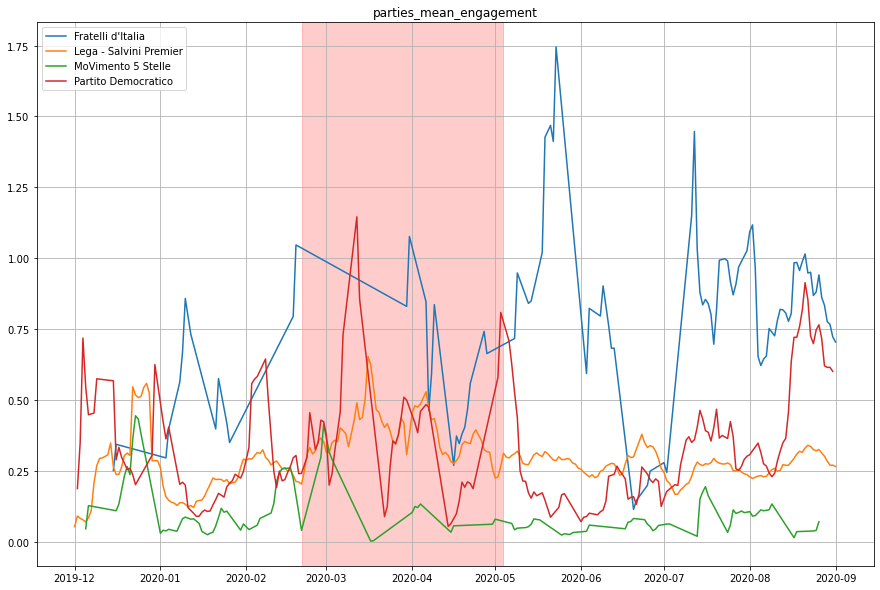

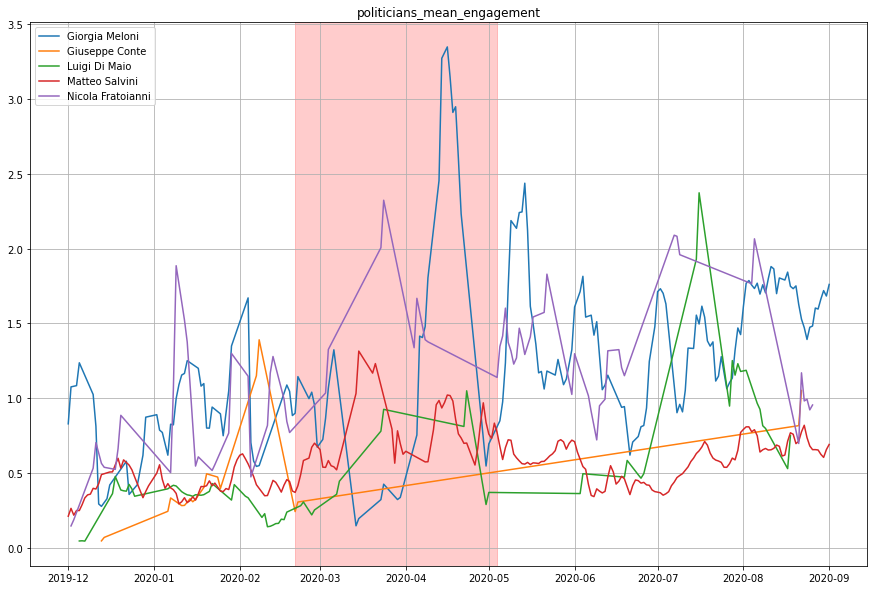

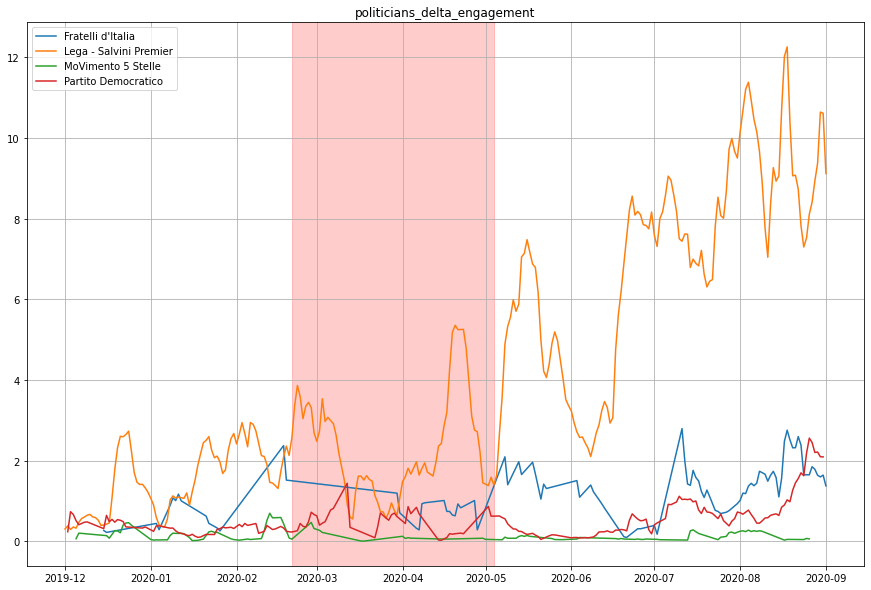

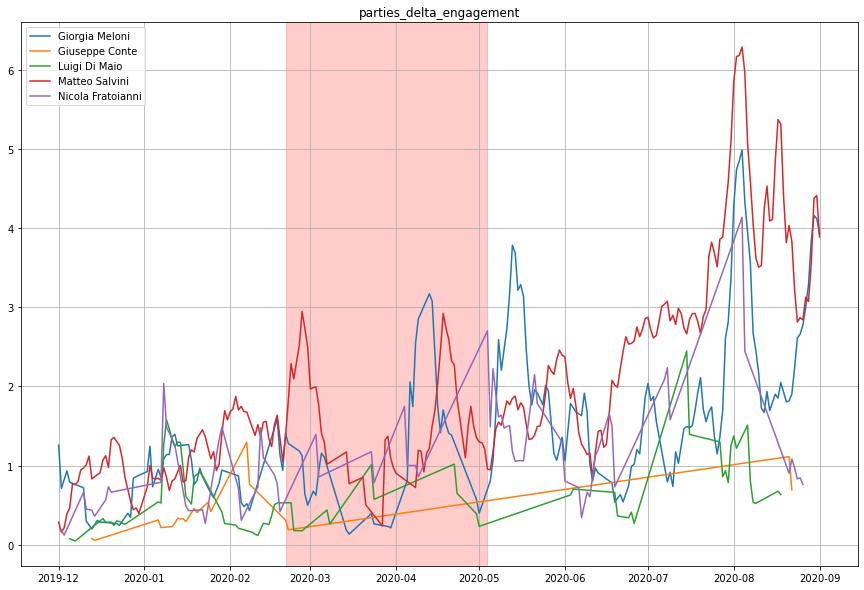

In [36]:
plot_ma(account_rolling_map, N_DAYS, parties, "parties_mean_engagement")
plot_ma(account_rolling_map, N_DAYS, politicians, "politicians_mean_engagement")
plot_ma(account_df_delta_map_final, N_DAYS, parties, "politicians_delta_engagement")
plot_ma(account_df_delta_map_final, N_DAYS, politicians, "parties_delta_engagement")

for name, df in account_df_delta_map_final.items():
    plot_ma(
        account_df_delta_map_final, N_DAYS, [name], "{}_delta_engagement".format(name)
    )

for name, df in account_rolling_map.items():
    plot_ma(account_rolling_map, N_DAYS, [name], "{}_mean_engagement".format(name))

In [ ]:
for name, df in account_df_delta_map_final.items():
    print(name)
    print(len(df))
    print("=" * 75)

### Experiments

In [ ]:
# df_time_series_simple

In [ ]:
# df_time_series = df_time_series.set_index("date")

In [ ]:
# df_time_series = df_time_series.sort_index()

In [ ]:
# groups_by_id = df_time_series.groupby(["id"])

In [ ]:
# Dict con chiave = date e valore => dict con chiave = nome_account e valore = lista di id_post pubblicati in quella data ()
# a quel punto parto dalla data minore, e da li costruisco finestre di 7 giorni. Per ogni giorno, l'engagement finale è dato
# dalla media rispetto a tutti i post a partire dall'inizio della finestra settimanale fino a quel giorno